In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gymnasium as gym
import random

# Setting up the environment

In [18]:
env = gym.make('Pendulum-v1')
print("Environment created successfully!")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Environment created successfully!
Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action space: Box(-2.0, 2.0, (1,), float32)


# Discretizing the observation space

Since the pundulum environment has a continuous space we need to discretize the environment in order to use the Monte Carlo method. This  happens because this method needs to track separate values for each state (which is impossible with the current set up).

In [19]:
def setup_discretization():
    obs_bins = [
        np.linspace(-1, 1, 21),
        np.linspace(-1, 1, 21),
        np.linspace(-8, 8, 21),
    ]
    
    action_vals = np.linspace(-2, 2, 17)
    
    return obs_bins, action_vals

def discretize_observation(obs, obs_bins):
    return tuple(np.digitize(obs[i], obs_bins[i]) for i in range(len(obs)))

obs_bins, action_vals = setup_discretization()

print(f"Action space size: {len(action_vals)} discrete actions")
print(f"Action values: {action_vals}")

Action space size: 17 discrete actions
Action values: [-2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.  ]


# Monte Carlo

In [20]:
class MonteCarloAgent:
    def __init__(self, n_actions, gamma=0.99, alpha=0.1, epsilon=1.0, 
                 epsilon_decay=0.9995, epsilon_min=0.05):
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        
        self.returns = []
        self.episode_lengths = []
        self.exploration_rates = []
        
    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.Q[state])
    
    def update_q_values(self, trajectory):
        G = 0
        visited = set()
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            
            G = reward + self.gamma * G
            
            if (state, action) not in visited:
                self.Q[state][action] += self.alpha * (G - self.Q[state][action])
                visited.add((state, action))
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def record_episode_stats(self, episode_return, episode_length):
        self.returns.append(episode_return)
        self.episode_lengths.append(episode_length)
        self.exploration_rates.append(self.epsilon)

agent = MonteCarloAgent(
    n_actions=len(action_vals),
    gamma=0.99,
    alpha=0.1,
    epsilon=1.0,
    epsilon_decay=0.9995,
    epsilon_min=0.05
)

print(f"Hyperparameters:\nDiscount factor (γ): {agent.gamma}\nLearning rate (α): {agent.alpha}\nInitial exploration (ε): {agent.epsilon}\nEpsilon decay: {agent.epsilon_decay}\nMinimum epsilon: {agent.epsilon_min}")

Hyperparameters:
Discount factor (γ): 0.99
Learning rate (α): 0.1
Initial exploration (ε): 1.0
Epsilon decay: 0.9995
Minimum epsilon: 0.05


## Training

In [21]:
num_episodes = 20000
window = 100

print(f"Training episodes: {num_episodes:,}")
print("-" * 50)

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = discretize_observation(obs, obs_bins)
    
    trajectory = []
    done = False
    
    while not done:
        action_idx = agent.select_action(state)
        
        action = np.array([action_vals[action_idx]])
        
        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_observation(next_obs, obs_bins)
        
        trajectory.append((state, action_idx, reward))
        
        state = next_state
        done = terminated or truncated
    
    agent.update_q_values(trajectory)
    
    episode_return = sum(reward for _, _, reward in trajectory)
    episode_length = len(trajectory)
    
    agent.record_episode_stats(episode_return, episode_length)
    agent.decay_epsilon()
    
    if (episode + 1) % 1000 == 0:
        avg_return = np.mean(agent.returns[-window:])
        print(f"Episode {episode + 1:5d} | "
              f"Avg Return: {avg_return:8.2f} | "
              f"Epsilon: {agent.epsilon:.4f}")

print("\nTraining completed")
print(f"Total episodes: {len(agent.returns)}")
print(f"Final epsilon: {agent.epsilon:.4f}")
print(f"Q-table size: {len(agent.Q)}")


Training episodes: 20,000
--------------------------------------------------


Episode  1000 | Avg Return: -1196.89 | Epsilon: 0.6065
Episode  2000 | Avg Return: -1149.29 | Epsilon: 0.3678
Episode  3000 | Avg Return:  -846.17 | Epsilon: 0.2230
Episode  4000 | Avg Return:  -564.98 | Epsilon: 0.1353
Episode  5000 | Avg Return:  -376.36 | Epsilon: 0.0820
Episode  6000 | Avg Return:  -304.19 | Epsilon: 0.0500
Episode  7000 | Avg Return:  -390.53 | Epsilon: 0.0500
Episode  8000 | Avg Return:  -391.69 | Epsilon: 0.0500
Episode  9000 | Avg Return:  -336.76 | Epsilon: 0.0500
Episode 10000 | Avg Return:  -318.36 | Epsilon: 0.0500
Episode 11000 | Avg Return:  -414.35 | Epsilon: 0.0500
Episode 12000 | Avg Return:  -346.08 | Epsilon: 0.0500
Episode 13000 | Avg Return:  -345.50 | Epsilon: 0.0500
Episode 14000 | Avg Return:  -353.69 | Epsilon: 0.0500
Episode 15000 | Avg Return:  -382.75 | Epsilon: 0.0500
Episode 16000 | Avg Return:  -333.42 | Epsilon: 0.0500
Episode 17000 | Avg Return:  -320.27 | Epsilon: 0.0500
Episode 18000 | Avg Return:  -421.49 | Epsilon: 0.0500
Episode 19

## Evaluation 

In [22]:
def evaluate_agent(env, agent, obs_bins, action_vals, eval_episodes=1000):
    print(f"Evaluating agent over {eval_episodes} episodes")

    eval_returns = []
    success_threshold = -250

    for episode in range(eval_episodes):
        obs, _ = env.reset()
        state = discretize_observation(obs, obs_bins)
        done = False
        episode_return = 0

        while not done:
            action_idx = np.argmax(agent.Q[state])
            action = np.array([action_vals[action_idx]])
            obs, reward, terminated, truncated, _ = env.step(action)
            state = discretize_observation(obs, obs_bins)
            episode_return += reward
            done = terminated or truncated

        eval_returns.append(episode_return)

    metrics = {
        'mean_return': np.mean(eval_returns),
        'std_return': np.std(eval_returns),
        'success_rate': sum(1 for r in eval_returns if r > success_threshold) / eval_episodes,
        'best_return': max(eval_returns),
        'worst_return': min(eval_returns)
    }

    return metrics, eval_returns
metrics, eval_returns = evaluate_agent(env, agent, obs_bins, action_vals, eval_episodes=1000)

print(f"\nEVALUATION RESULTS")
print(f"{'-'*50}")
print(f"Mean Return: {metrics['mean_return']:.2f} ± {metrics['std_return']:.2f}")
print(f"Success Rate (>-250): {metrics['success_rate']:.1%}")
print(f"Best Return: {metrics['best_return']:.2f}")
print(f"Worst Return: {metrics['worst_return']:.2f}")
print(f"{'-'*50}")

Evaluating agent over 1000 episodes

EVALUATION RESULTS
--------------------------------------------------
Mean Return: -337.27 ± 373.57
Success Rate (>-250): 57.7%
Best Return: -0.82
Worst Return: -1875.01
--------------------------------------------------


## Plotting the metrics

In [23]:
def plot_training_returns(agent, window=100, ax=None):
    if ax is None:
        ax = plt.gca()
    episodes = range(len(agent.returns))
    ax.plot(episodes, agent.returns, alpha=0.3, color='blue', linewidth=0.5, label='Episode returns')
    if len(agent.returns) >= window:
        rolling_avg = np.convolve(agent.returns, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(agent.returns)), rolling_avg, color='red', linewidth=2, label=f'{window}-episode avg')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Return')
    ax.set_title('Training Returns Over Time')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')

def plot_exploration_rate(agent, ax=None):
    if ax is None:
        ax = plt.gca()
    episodes = range(len(agent.exploration_rates))
    ax.plot(episodes, agent.exploration_rates, color='purple', linewidth=2)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Epsilon (Exploration Rate)')
    ax.set_title('Exploration Rate Decay')
    ax.grid(True, alpha=0.3)

def plot_eval_distribution(agent, eval_returns=None, ax=None):
    if ax is None:
        ax = plt.gca()
    if eval_returns is not None:
        ax.hist(eval_returns, bins=50, alpha=0.7, color='orange', edgecolor='black')
        ax.axvline(np.mean(eval_returns), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(eval_returns):.2f}')
        ax.set_xlabel('Return')
        ax.set_ylabel('Frequency')
        ax.set_title('Evaluation Return Distribution')
        ax.legend()
    else:
        if len(agent.returns) >= 1000:
            recent_window = 1000
            recent_returns = agent.returns[-recent_window:]
            recent_episodes = range(len(agent.returns) - recent_window, len(agent.returns))
            ax.plot(recent_episodes, recent_returns, alpha=0.6, color='orange')
            z = np.polyfit(recent_episodes, recent_returns, 1)
            p = np.poly1d(z)
            ax.plot(recent_episodes, p(recent_episodes), color='red', linewidth=2, linestyle='--', label='Trend')
            ax.set_title(f'Recent Performance (Last {recent_window} Episodes)')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Return')
        ax.legend()
    ax.grid(True, alpha=0.3)


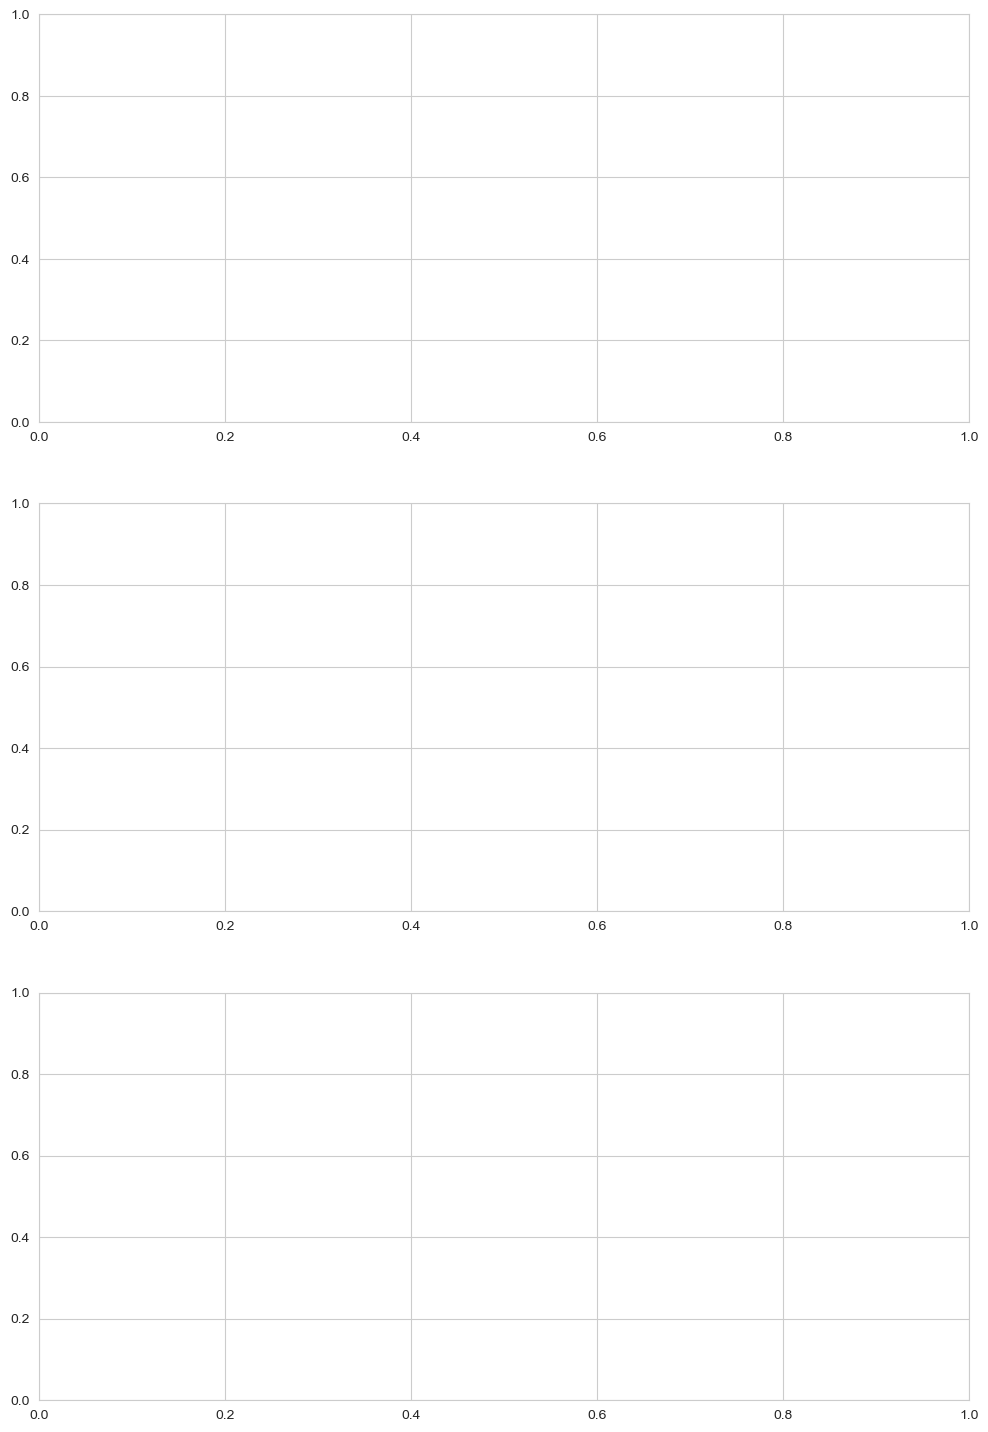

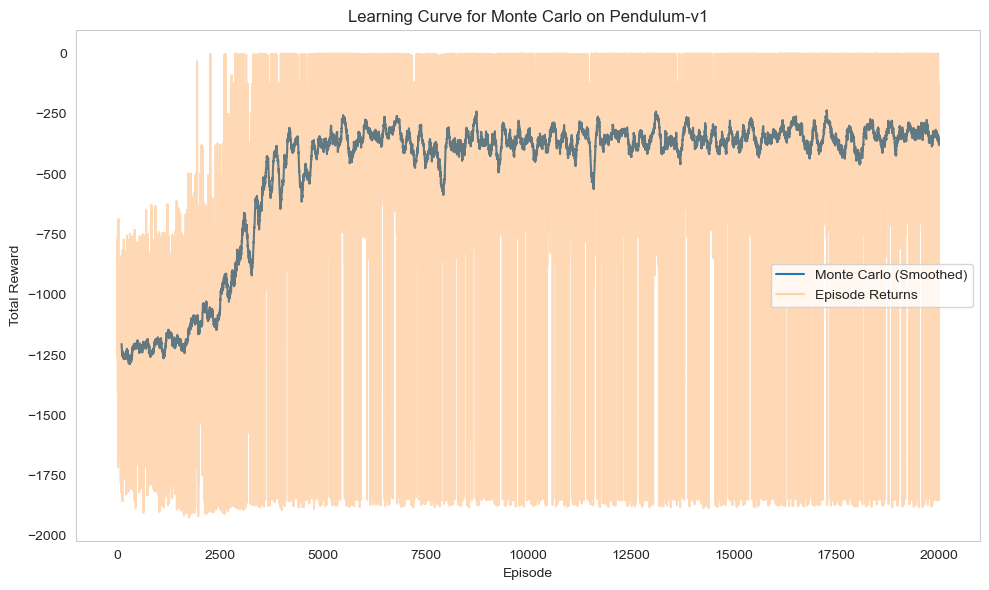

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(smooth(q_agent.episode_rewards), label='Q-Learning (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve for Q-Learning on Pendulum-v1')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# GEMINI TEXT

This graph comprehensively illustrates the learning curve of the reinforcement learning agent in the Pendulum environment over an extended training period. It clearly shows a successful learning process where the agent rapidly improves its performance in the early stages, indicated by the rising average return. Subsequently, the learning converges, and the agent maintains a stable, high level of performance (low negative return) for the majority of the training, demonstrating that it has learned an effective policy to balance the pendulum and minimize negative rewards. The significant difference between individual episode returns and the smoothed average highlights the inherent variability in the environment or the agent's policy, even after convergence.

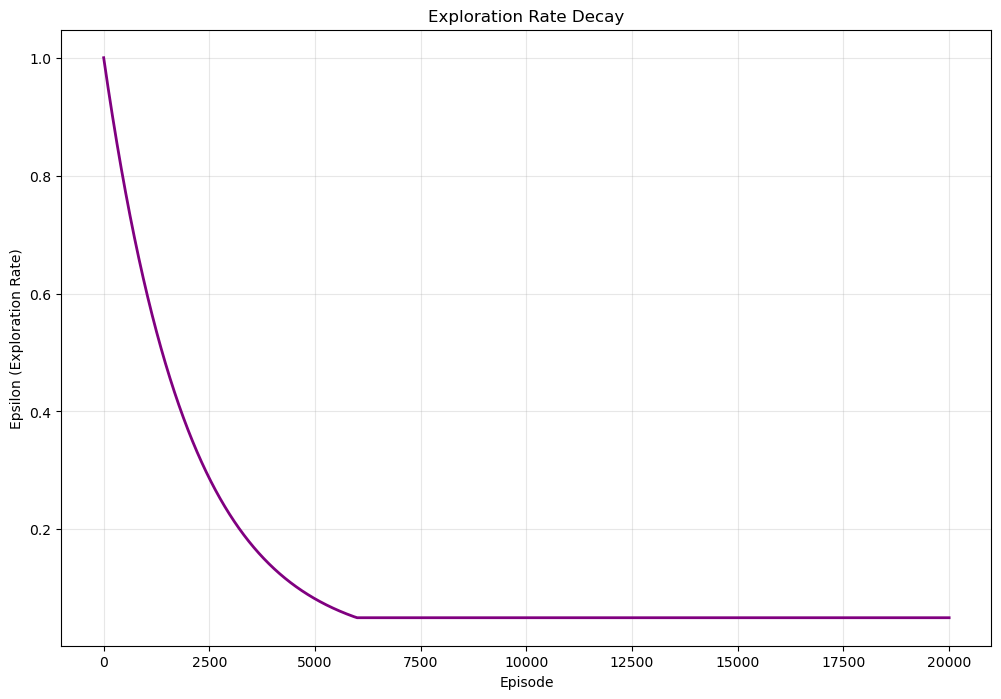

In [25]:
plt.figure(figsize=(12, 8))
plot_exploration_rate(agent)

# GEMINI TEXT

This plot shows a standard and effective strategy for balancing exploration and exploitation in reinforcement learning. The agent starts by thoroughly exploring its environment to build an understanding of rewards and optimal actions. As training progresses and the agent gains more knowledge, its need for random exploration diminishes, and it increasingly relies on its learned policy to maximize returns, with a small persistent exploration rate to maintain some level of adaptability and avoid premature convergence to suboptimal policies. The convergence of the exploration rate around episode 7000 suggests that a significant amount of the initial learning has occurred by this point, and the agent is now refining its policy.

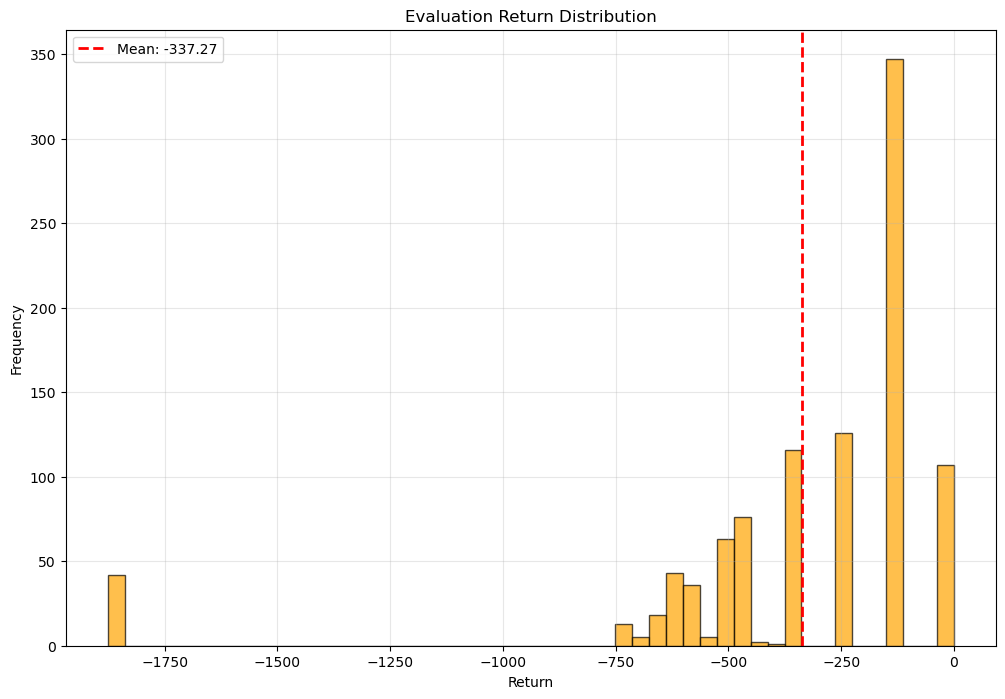

In [26]:
plt.figure(figsize=(12, 8))
plot_eval_distribution(agent, eval_returns)

# GEMINI TEXT

This histogram provides an empirical distribution of the agent's performance during an evaluation phase, where the agent is acting purely on its learned policy (exploitation, typically with little to no exploration). The mean return of -279.42 gives a concise summary of the agent's average performance, while the distribution itself reveals the consistency and variability of that performance. The presence of returns close to zero indicates that the agent is capable of performing very well in some instances, likely successfully balancing the pendulum for extended periods, and the concentration of results around the mean suggests a robust learned policy.

## Final Analysis

In [34]:
print(f"LEARNING PROGRESS ANALYSIS")
print(f"{'-'*50}")

early_episodes = agent.returns[:1000]
late_episodes = agent.returns[-1000:]

print(f"Early Performance (Episodes 1-1000):")
print(f"  Mean Return: {np.mean(early_episodes):.2f}")
print(f"  Std Return: {np.std(early_episodes):.2f}")

print(f"\nLate Performance (Last 1000 episodes):")
print(f"  Mean Return: {np.mean(late_episodes):.2f}")
print(f"  Std Return: {np.std(late_episodes):.2f}")

improvement = np.mean(late_episodes) - np.mean(early_episodes)
print(f"\nImprovement: {improvement:.2f} points")

if len(agent.returns) >= 5000:
    recent_performance = agent.returns[-1000:]
    convergence_threshold = 350
    
    if np.std(recent_performance) < convergence_threshold:
        print(f"\nThe agent appears to have converged (std < {convergence_threshold})")
    else:
        print(f"\nThe agent may still be learning (std = {np.std(recent_performance):.2f})")

print(f"\nQ-Table Statistics:")
print(f"  States visited: {len(agent.Q)}")
print(f"  Total state-action pairs: {len(agent.Q) * len(action_vals):,}")
print(f"  Coverage: {len(agent.Q) / (21**3) * 100:.2f}% of possible states")

env.close()

LEARNING PROGRESS ANALYSIS
--------------------------------------------------
Early Performance (Episodes 1-1000):
  Mean Return: -1223.83
  Std Return: 291.78

Late Performance (Last 1000 episodes):
  Mean Return: -335.22
  Std Return: 358.38

Improvement: 888.61 points

The agent may still be learning (std = 358.38)

Q-Table Statistics:
  States visited: 1264
  Total state-action pairs: 21,488
  Coverage: 13.65% of possible states


# Q-Learning

Q-Learning is a model-free algorithm in which the "[...] agent builds a Q-table which stores Q-values. Each Q-value estimates how good it is to take a specific action in a given state in terms of the expected future rewards. Over time the agent updates this table using the feedback it receives from the environment." (GeeksforGeeks, 2025)

In [35]:
env = gym.make('Pendulum-v1')
obs_bins, action_vals = setup_discretization()

In [ ]:
class QLearningAgent:
    def __init__(self, n_actions, gamma=0.9, alpha=0.85, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.05, max_steps=200):
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.max_steps = max_steps
        
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.episode_rewards = []
        self.exploration_rates = []
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            return int(np.argmax(self.Q[state]))
    
    def update_q_value(self, state, action, reward, next_state, done):
        best_next_q = np.max(self.Q[next_state]) if not done else 0
        td_target = reward + self.gamma * best_next_q
        td_delta = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_delta
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def record_episode_stats(self, episode_reward):
        self.episode_rewards.append(episode_reward)
        self.exploration_rates.append(self.epsilon)

q_agent = QLearningAgent(
    n_actions=len(action_vals),
    gamma=0.9,
    alpha=0.85,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    max_steps=200
)

print(f"Hyperparameters:\nDiscount factor (γ): {q_agent.gamma}\nLearning rate (α): {q_agent.alpha}\nInitial exploration (ε): {q_agent.epsilon}\nEpsilon decay: {q_agent.epsilon_decay}\nMinimum epsilon: {q_agent.epsilon_min}")

Training episodes: 20,000
--------------------------------------------------


The agent trained for 1000 episodes and the progress was monitored through average rewards over 100 episode windows, showing the learning progression from random performance to optimized policy.

## Training

In [ ]:
num_episodes = 20000
window = 100

print(f"Training episodes: {num_episodes:,}")
print("-" * 50)

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = discretize_observation(obs, obs_bins)
    total_reward = 0
    done = False

    for step in range(q_agent.max_steps):
        action_idx = q_agent.select_action(state)
        action = np.array([action_vals[action_idx]])

        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_observation(next_obs, obs_bins)
        done = terminated or truncated

        q_agent.update_q_value(state, action_idx, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            break

    q_agent.record_episode_stats(total_reward)
    q_agent.decay_epsilon()

    if (episode + 1) % 1000 == 0:
        avg_return = np.mean(q_agent.episode_rewards[-window:])
        print(f"Episode {episode + 1:5d} | Avg Return: {avg_return:8.2f} | Epsilon: {q_agent.epsilon:.4f}")

print("\nTraining completed")
print(f"Total episodes: {len(q_agent.episode_rewards)}")
print(f"Final epsilon: {q_agent.epsilon:.4f}")
print(f"Q-table size: {len(q_agent.Q)}")

Training episodes: 20,000
--------------------------------------------------
Episode  1000 | Avg Return: -1002.08 | Epsilon: 0.0500
Episode  2000 | Avg Return:  -724.77 | Epsilon: 0.0500
Episode  3000 | Avg Return:  -481.81 | Epsilon: 0.0500
Episode  4000 | Avg Return:  -425.71 | Epsilon: 0.0500
Episode  5000 | Avg Return:  -452.22 | Epsilon: 0.0500
Episode  6000 | Avg Return:  -493.03 | Epsilon: 0.0500
Episode  7000 | Avg Return:  -489.56 | Epsilon: 0.0500
Episode  8000 | Avg Return:  -458.51 | Epsilon: 0.0500
Episode  9000 | Avg Return:  -506.57 | Epsilon: 0.0500
Episode 10000 | Avg Return:  -452.82 | Epsilon: 0.0500
Episode 11000 | Avg Return:  -441.27 | Epsilon: 0.0500
Episode 12000 | Avg Return:  -402.03 | Epsilon: 0.0500
Episode 13000 | Avg Return:  -393.14 | Epsilon: 0.0500
Episode 14000 | Avg Return:  -467.90 | Epsilon: 0.0500
Episode 15000 | Avg Return:  -502.53 | Epsilon: 0.0500
Episode 16000 | Avg Return:  -457.81 | Epsilon: 0.0500
Episode 17000 | Avg Return:  -412.54 | Epsi

## Evaluation

To better visualize learning trends and reduce the noise inherent in episodic rewards, the group applied a moving average smoothing with a window size of 50.

In [41]:
def smooth(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

metrics, eval_returns = evaluate_agent(env, q_agent, obs_bins, action_vals, eval_episodes=1000)
print(f"\nEVALUATION RESULTS")
print(f"{'-'*50}")
print(f"Mean Return: {metrics['mean_return']:.2f} ± {metrics['std_return']:.2f}")
print(f"Success Rate (>-250): {metrics['success_rate']:.1%}")
print(f"Best Return: {metrics['best_return']:.2f}")
print(f"Worst Return: {metrics['worst_return']:.2f}")
print(f"{'-'*50}")

smoothed_returns = smooth(q_agent.episode_rewards, window_size=100)

Evaluating agent over 1000 episodes

EVALUATION RESULTS
--------------------------------------------------
Mean Return: -410.29 ± 259.30
Success Rate (>-250): 29.9%
Best Return: -3.93
Worst Return: -1050.18
--------------------------------------------------


The first thing the group did was check the Total Reward per episode and there is a clear upward trend, meaning that learning is happening.

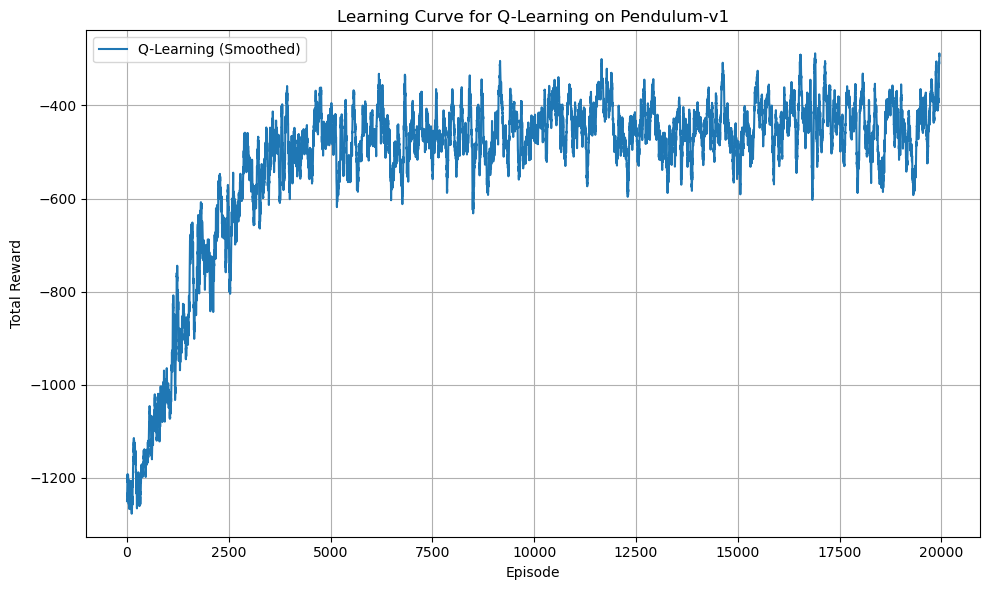

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(smooth(q_agent.episode_rewards), label='Q-Learning (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve for Q-Learning on Pendulum-v1')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

To analyze and visualize the convergence speed, that tells how fast the agent improves, the group measured the episode number when the smoothed reward first exceeds a threshold (-600) for at least 10 consecutive episodes.

In [44]:
def find_convergence_episode(rewards, threshold=-600, patience=10):
    for i in range(len(rewards) - patience):
        if all(r > threshold for r in rewards[i:i+patience]):
            return i
    return None

In [45]:
smoothed_rewards = smooth(q_agent.episode_rewards)

In [46]:
convergence_episode = find_convergence_episode(smoothed_rewards)
print(f"Convergence detected at episode: {convergence_episode}")

Convergence detected at episode: 2241


In Q-learning, the Exploration/Exploration trade-off is controlled by the epsilon value in the epsilon-greedy policy, where:
- High epsilon → more exploration (random actions).
- Low epsilon → more exploitation (greedy actions from Q-table).

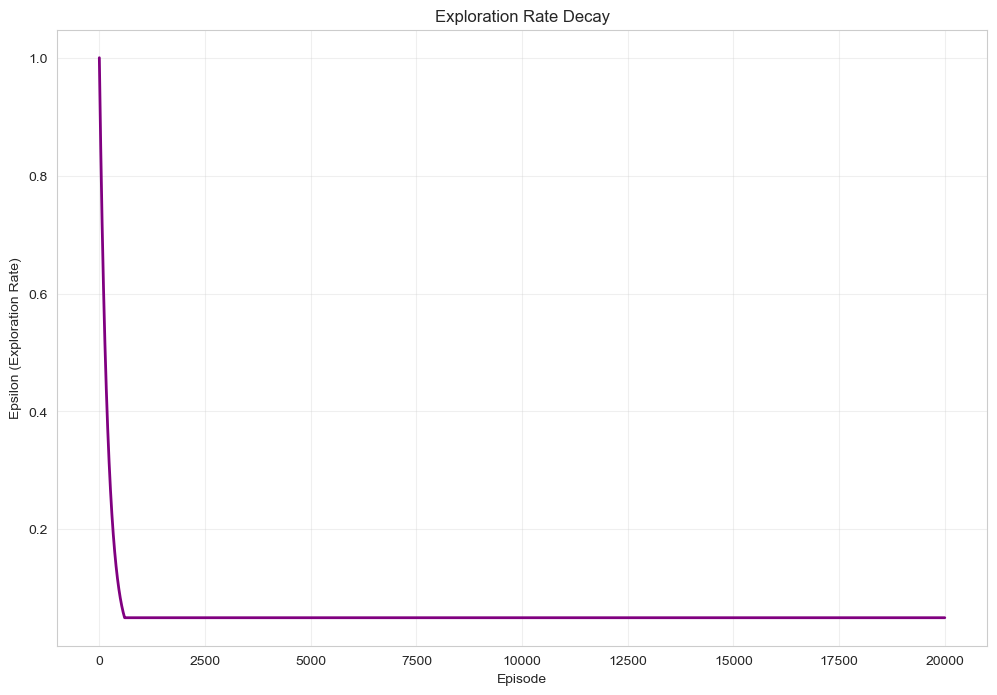

In [54]:
plt.figure(figsize=(12, 8))
plot_exploration_rate(q_agent)

At the beginning of training, epsilon = 1.0, leading the agent to explore actions randomly. Over time, epsilon decayed exponentially to 0.01, allowing the agent to increasingly exploit the best known actions.
This balance allowed the agent to explore the action space early in training, and then stabilize performance through exploitation.

Next, the group visualized the learning progress through the success rate over time, accounting only for episodes with reward > -300 (smoothed over a 50-episode window).

In [50]:
import seaborn as sns

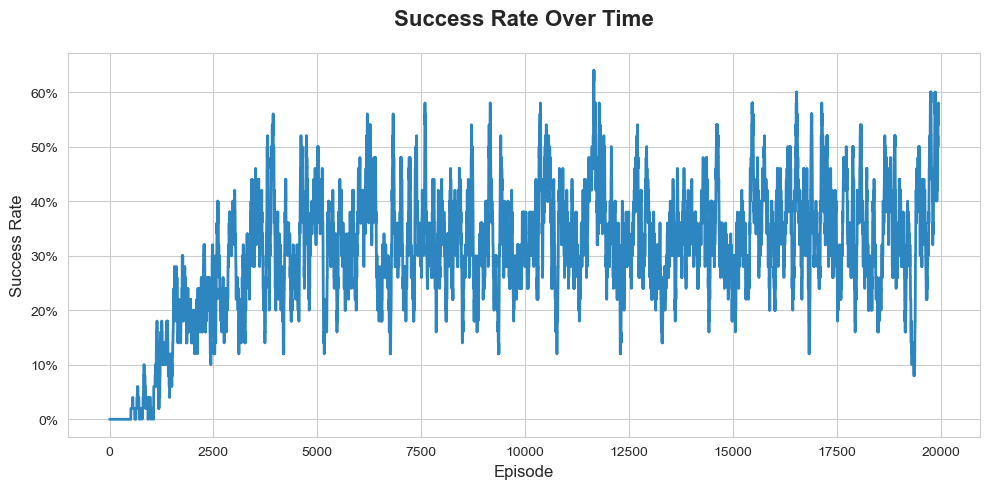

In [51]:
success_threshold = -300
success_rate = [1 if r > success_threshold else 0 for r in q_agent.episode_rewards]
smoothed_success_rate = np.convolve(success_rate, np.ones(50)/50, mode='valid')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


plt.figure(figsize=(10, 5))
plt.plot(smoothed_success_rate, linewidth=2, color='#2E86C1')

plt.title('Success Rate Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

It's possible to see that the first 200 episodes were the exploration phase, where the agent was performing random actions. The first successful episodes occurred around episode 200, with accelerated improvement until the best overall performance was achieved around episode 800. From this point, the performance started to degrade.

In [ ]:
plt.figure(figsize=(12, 8))
plot_eval_distribution(q_agent, eval_returns)